In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from scipy.optimize import minimize
from scipy.stats import chi2
from scipy.integrate import simps
from tqdm import tqdm

In [49]:
###this code calculates either the  Neyman Pearson test statistic (NP) or the profile likelihood test statistic (PL) for the (unrealistic scenario) where we are purely counting events

### we say the number of events is n_b + \mu * n_s, where \mu is the signal strength wrt to the SM.

####For the NP TS  we assume our null hypothesis is background events only (100), and our alternative hypothesis is signal and background, where \mu is one. 

###  In reality it is rare you will have such an exact null and alternative hypothesis. For the PL, we imagine you have a good estimate of the background, so you can fix that. However, the signal strength (mu) you estimate based on the data. The null is therefore backgroud events only (100) and  the alternative is 100 + mu_hat*30 


# Given values

scale_factor = 1 ##can ignore - just for varying size of sample
n_b_true = 100*scale_factor  # True expected number of events (NULL)
n_s_true = 30*scale_factor
n_b_and_s_true = n_b_true + n_s_true # True expected number of events (ALTERNATIVE)

# Define the negative log-likelihood function
def neg_log_likelihood(mu, n_obs):
    n_exp = mu * n_s_true + n_b_true
    log_likelihood = n_obs * np.log(n_exp) - n_exp
    return -log_likelihood  # We negate it because we want to minimize



###########################################################################################



def make_test_statistics(mu):
    num_samples = 10000  # Number of random samples
    n_true = n_b_true + mu*n_s_true
    
    # Draw num_samples random values from a Poisson distribution with mean n_true
    random_n_obs = np.random.poisson(n_true, num_samples)
    

    # List to store MLE estimates for each random sample
    mu_hats = []
    errors = []
    n_b_and_s_MLE = []

    # Perform MLE for each random sample
    for n_obs in tqdm(random_n_obs):
        # Minimize the negative log-likelihood for each sample
        ##in order to make mu not go below zero, change -100 to 0 in the bound argument
        result = minimize(neg_log_likelihood, 0.1, args=(n_obs,), bounds=[(0, None)])  # mu must be >= 0

        if result.success:
            hessian_inv_dense = result.hess_inv.todense()  # Approximate Hessian inverse
            error_mu_hat = np.sqrt(hessian_inv_dense[0, 0])  # Square root of the diagonal element
            errors.append(error_mu_hat)
        else:
            errors.append(None) 

        
        mu_hat = result.x[0]
        mu_hats.append(mu_hat)
        n_b_and_s_MLE.append(mu_hat*n_s_true + n_b_true)

    # Print the MLE estimates for the first few samples
    print(mu_hats[:10])  # Displaying the first 10 MLE estimates
    print(errors[:10])
    ##Neyman-Pearson (NP) qNP = -2ln (L(H0)/L(H1)), L(H0)  = Prob(x|H0) = Prob(x | n_b_true) etc

    likelihoods_np = [-2*math.log(stats.poisson.pmf(n_obs, n_b_true)/stats.poisson.pmf(n_obs, n_b_and_s_true)) for n_obs in random_n_obs]


    ##Profile-Likelihod (LH) qLH = -2ln (L(X|\mu = 0)/L(X|\mu = \mu_hat))

    likelihoods_pl = [-2*math.log(stats.poisson.pmf(n_obs, n_b_true)/stats.poisson.pmf(n_obs, n_estimate)) for n_obs, n_estimate in zip(random_n_obs,n_b_and_s_MLE)]

    pulls = (np.array(mu_hats) - mu)/np.array(errors)
    
    return likelihoods_np,likelihoods_pl, random_n_obs, mu_hats, errors, pulls

In [56]:
n_obs=137
result = minimize(neg_log_likelihood, 0.1, args=(n_obs,), bounds=[(-100, None)])  # mu must be >= 0
mu_hat = result.x[0]
print('mu_hat:', mu_hat)

if result.success:
    hessian_inv_dense = result.hess_inv.todense()  # Approximate Hessian inverse
    error_mu_hat = np.sqrt(hessian_inv_dense[0, 0])  # Square root of the diagonal element
    print('error:', error_mu_hat)

print('3 sigma: [', mu_hat - 3*error_mu_hat, ',', mu_hat + 3*error_mu_hat, ']')

mu_hat: 1.2333321608934358
error: 0.38974062376977414
3 sigma: [ 0.06411028958411347 , 2.402554032202758 ]


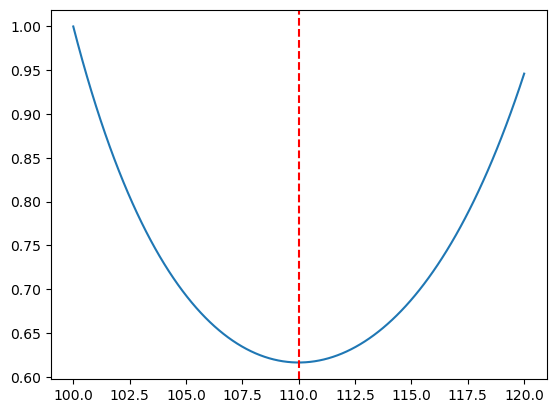

In [27]:
n_obs = 110
n_estimate = np.linspace(n_obs - 10, n_obs + 10, 100)
likelihood = stats.poisson.pmf(n_obs, n_b_true)/stats.poisson.pmf(n_obs, n_estimate)
plt.plot(n_estimate, likelihood)
plt.axvline(x=n_obs, color='r', linestyle='--', label='True Signal Strength')

In [50]:
##generate under null (background only)
#In reality you would normally only generate under null, unless you are also doing sensivitiy studies

lh_np_null, lh_pl_null,n_null, mu_hats_null, mu_errors_null, pulls_null = make_test_statistics(mu  = 0)

##generate under alternative (background + signal (mu = 1))
lh_np_alt, lh_pl_alt, n_alt, mu_hats_alt, mu_errors_alt, pulls_alt = make_test_statistics(mu = 1)


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:14<00:00, 697.44it/s]


[0.40000168798838615, 0.0, 0.13333382107006975, 0.40000168798838615, 0.0, 0.43333518858131354, 0.0, 0.0, 0.19999880289974944, 0.0]
[0.3527191824849588, 1.0, 0.3383034056223568, 0.3527191824849588, 1.0, 0.3541927164329822, 1.0, 1.0, 0.34343486307347065, 1.0]


100%|██████████| 10000/10000 [00:20<00:00, 493.19it/s]


[0.8333327360516101, 0.7333331433366157, 0.8333327360516101, 1.3666633752447375, 1.3666633752447375, 1.4333331204254802, 0.7666660422210552, 0.29999999646208225, 0.6666669763492808, 1.1999965811824649]
[0.37259079649422244, 0.36794464040778124, 0.37259079649422244, 0.3955437193745092, 0.3955437193745092, 0.3983020423240546, 0.369451870425735, 0.3482089291117023, 0.3648209652965454, 0.38767013464927064]


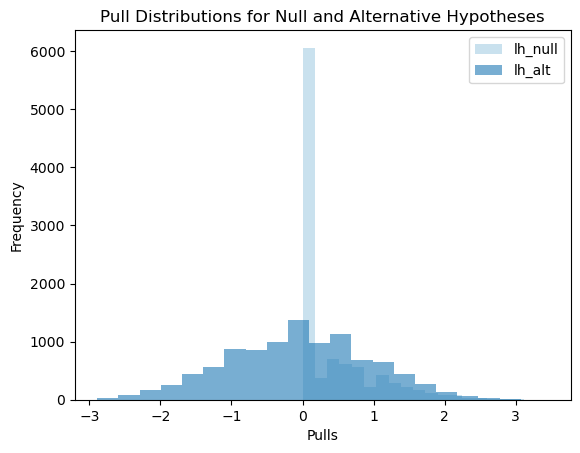

Coverage Probability (Null): 0.85
Coverage Probability (Alternative): 0.66


In [51]:
# Define colors: lighter and darker shades for np and pl
color_np_light = '#a6cee3'  # Lighter shade for np
color_np_dark = '#1f78b4'   # Darker shade for np
color_pl_light = '#b2df8a'  # Lighter shade for pl
color_pl_dark = '#33a02c'   # Darker shade for pl

#plt.figure(figsize=(10, 6))
plt.hist((np.array(mu_hats_null)-0)/np.array(mu_errors_null), bins=20, alpha=0.6, color=color_np_light, label='lh_null')
plt.hist((np.array(mu_hats_alt)-1)/np.array(mu_errors_alt), bins=20, alpha=0.6, color=color_np_dark, label='lh_alt')
plt.xlabel('Pulls')
plt.ylabel('Frequency')
plt.title('Pull Distributions for Null and Alternative Hypotheses')
plt.legend()
plt.show()

# Calculate the coverage probability of the confidence intervals from the pull distributions
coverage_null = np.sum((pulls_null - 1 <= 0) & (pulls_null + 1 >= 0)) / len(pulls_null)
coverage_alt = np.sum((pulls_alt - 1 <= 0) & (pulls_alt + 1 >= 0)) / len(pulls_alt)
print(f'Coverage Probability (Null): {coverage_null:.2f}')
print(f'Coverage Probability (Alternative): {coverage_alt:.2f}')



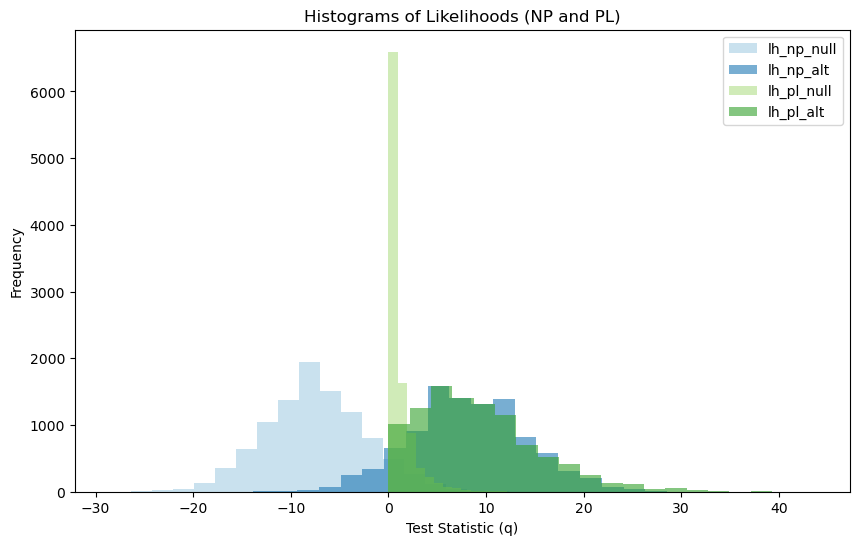

10000


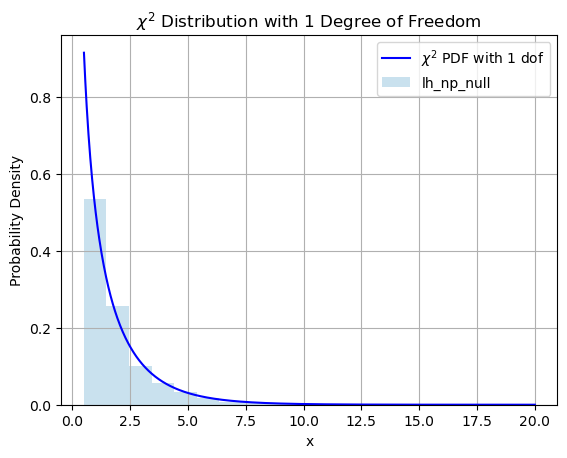

In [48]:

# Create the histograms of test statistics
plt.figure(figsize=(10, 6))
plt.hist(lh_np_null, bins=20, alpha=0.6, color=color_np_light, label='lh_np_null')
plt.hist(lh_np_alt, bins=20, alpha=0.6, color=color_np_dark, label='lh_np_alt')
plt.hist(lh_pl_null, bins=20, alpha=0.6, color=color_pl_light, label='lh_pl_null')
plt.hist(lh_pl_alt, bins=20, alpha=0.6, color=color_pl_dark, label='lh_pl_alt')

# Add labels and title
plt.xlabel('Test Statistic (q)')
plt.ylabel('Frequency')
plt.title('Histograms of Likelihoods (NP and PL)')
plt.legend()
plt.show()



###put a chi2 with 1 dof on top of lh profile under the null

xmin, xmax = 0.5,20
x = np.linspace(xmin, xmax,1000)
print(len(lh_pl_null))

# Compute the chi-square PDF with 1 degree of freedom and normalise
chi2_pdf = chi2.pdf(x, df=1)
cdf_b = chi2.cdf(xmin, df=1)
cdf_a = chi2.cdf(xmax, df=1)
integral = cdf_b - cdf_a

# Plot the chi-square PDF
plt.plot(x, chi2_pdf/-integral, label=r'$\chi^2$ PDF with 1 dof', color='blue')
plt.hist(lh_pl_null, bins=20, range = (xmin,xmax),density = True,  alpha=0.6, color=color_np_light, label='lh_np_null')
# Add labels and a title
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title(r'$\chi^2$ Distribution with 1 Degree of Freedom')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

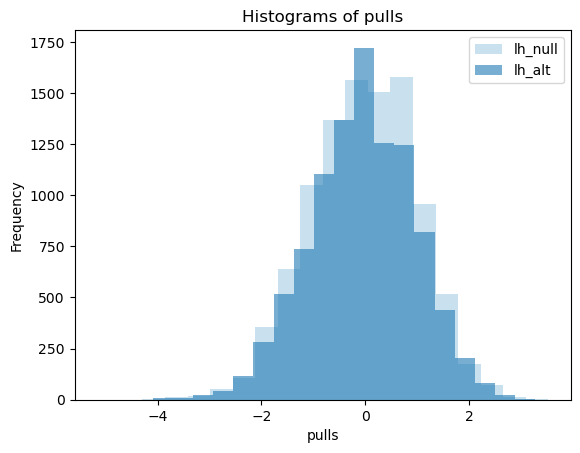

In [44]:
plt.hist(pulls_null, bins=20, alpha=0.6, color=color_np_light, label='lh_null')
plt.hist(pulls_alt, bins=20, alpha=0.6, color=color_np_dark, label='lh_alt')
plt.xlabel('pulls')
plt.ylabel('Frequency')
plt.title('Histograms of pulls')
plt.legend()